<a href="https://colab.research.google.com/github/mohammadsanaee/ML_in_application/blob/main/5_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
if 'harbour-space-text-mining-course' not in sys.path:
    sys.path.append('harbour-space-text-mining-course')

# from tmcourse.demo import (
# )
# from tmcourse.quiz import (
# )
from tmcourse.ipyquiz import Quiz, Function
from tmcourse.utils import enable_mathjax_in_cell

from IPython.display import HTML, display

# get_ipython().events.register('pre_run_cell', enable_mathjax_in_cell)
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)


Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 738, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 738 (delta 79), reused 158 (delta 69), pack-reused 563
Receiving objects: 100% (738/738), 179.50 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (403/403), done.
Updating files: 100% (129/129), done.


<!--@slideshow slide-->
<center><h1>Recurrent Neural Networks</h1></center>

<!--@slideshow slide-->
# Outline
1. Motivation: order matters
1. Sequences and recurrent functions
1. Recurrent Neural Networks
1. RNN for classification and language modeling

<!--@slideshow slide-->
# Motivation: order matters

<!--@slideshow slide-->
- Machine Learning algorithms (and Neural Networks in particular) require to represent data as vectors (or tensors in general)
- So far, we represented texts as vectors using one-hot encoding

<!--@slideshow fragment-->
**Problem**: one-hot encoding loses order of words!

**Example**: two different hotel reviews
- "great location, but poor experience overall"
- "poor location, but great experience overall"

Both have the same vector representation.


<!--@slideshow fragment-->
**What we want**: figure out how to process _sequences_ as inputs for neural networks.

<!--@slideshow slide-->
# Sequences and recurrent functions

<!--@slideshow slide-->
**Toy example**: for a sequence of numbers $x_1, x_2, \dots, x_t, \dots$, for each $t$ compute the average value $y_t$.

**Our goal**:  _organize computations over sequences_ in the most general way.

<!--@slideshow slide-->
- $x_1 = 5 \rightarrow y_1 = 5$

<!--@slideshow fragment-->
- $x_2 = 3 \rightarrow y_2 = \dfrac{3 + 5}{2} = 4$


<!--@slideshow fragment-->
- $x_3 = 10 \rightarrow y_3 = \dfrac{3 + 5 + 10}{3} = 6$


<!--@slideshow fragment-->
- $\dots$

<!--@slideshow slide-->
Let's organize computations as follows:

- Keep the _hidden state_: the sum of previous elements $s_t$ and the number of previous elements $n_t$
$$
s_0 = 0, n_0 = 0
$$
- For each $t$:
  - Update the hidden state:
$$
s_t = s_{t-1} + x_t
$$
$$
n_t = n_{t-1} + 1
$$
  - Compute the output:
$$
y_t = \dfrac{s_t}{n_t}
$$

<!--@slideshow fragment-->

Abstracting from the concrete algorithm, this is what we are doing:
- Update the hidden state:
$$
h_t = f(\color{red}{h_{t-1}}, x_t)
$$
- Compute the output from the hidden state:
$$
y_t = g(\color{red}{h_{t}})
$$

<!--@slideshow fragment-->
For this particular problem, we know the functions $f$ and $g$. In general, we will **learn them from data**.

<!--@slideshow slide-->
![alt text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/ml_vs_cs.png)

<!--@slideshow slide-->
The function
$$
h_t = f(h_{t-1}, x_t)
$$
is a _recurrent function_, because it depends on its previous values.

<!--@slideshow fragment-->
We can "unroll" it back in time:
$$
h_t = f(h_{t-1}, x_t)
$$


<!--@slideshow fragment-->
$$
= f(f(h_{t-2}, x_{t-1}), x_t)
$$


<!--@slideshow fragment-->
$$
= f(f(f(h_{t-3}, x_{t-2}), x_{t-1}), x_t)
$$


<!--@slideshow fragment-->
$$
\dots
$$


<!--@slideshow fragment-->
$$
= f(f(f(\dots \color{red}{f(h_0, x_1)} \dots, x_{t-2}), x_{t-1}), x_t)
$$


<!--@slideshow fragment-->
So it has a _dynamic_ computational graph (built while reading the sequence $x_t$).

<!--@slideshow slide-->
Computational graphs may be different:

<center><img src="https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/rnn-all.png"></center>

<!--@slideshow slide-->
"Vanilla" (non-recurrent) function: one input, one output.

<center><img src="https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/rnn-nn.png"></center>

<!--@slideshow slide-->
Classification of a sequence: read the full sequence, return the predicted label in the end.

<center><img src="https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/rnn-classification.png"></center>

<!--@slideshow slide-->
Language Model: for each input word, predict the next word.

<center><img src="https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/rnn-lm.png"></center>

<!--@slideshow slide-->
# Recurrent Neural Networks

<!--@slideshow slide-->
We formalize computations over sequences using recurrent functions:
$$
h_t = f(h_{t-1}, x_t)
$$
$$
y_t = g(h_{t})
$$

**Our goal**: learn functions $f$ and $g$ from data.

<!--@slideshow slide-->
**Idea**: $f$ and $g$ are _layers_.
$$
f(h_{t-1}, x_t) = \mathrm{SomeFunction}(W_{hh}h_{t-1} + W_{xh} x_t)
$$
$$
y_t = \mathrm{SomeFunction}(W_{hy} h_t)
$$

Where $\mathrm{SomeFunction}$ may be $\mathrm{relu}$, $\mathrm{tanh}$, identity, ...

<!--@slideshow fragment-->
**Q**: how to find $W_{hh}, W_{xh}, W_{hy}$?

**A**: "unroll" the computational graph and use backpropagation.

<!--@slideshow slide-->
# Colab demo: classification with RNN

`ClassificationRNN` implements a Recurrent Neural Network for classification:
- Read the input sequence $x_1, x_2, \dots, x_t, \dots$
- Outputs are probability distributions over classes.
- Update hidden states and outputs according to RNN equations:
$$
h_t = f(h_{t-1}, x_t)
$$
$$
y_t = g(h_t)
$$
- The last output is the result of classification: it is compared with the true category.


In [ ]:
import torch.nn as nn

class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # instead of explicit matrix multiplications, we use Linear layers
        # W_hh: hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # W_xh: input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # W_hy: hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)

        # nonlinearities we will use:
        # ReLU for h_t = f(h_{t-1}, x_t)
        self.relu = nn.ReLU()
        # LogSoftmax for y_t = g(h_t) (because we are doing classification)
        # for binary classification, it is 1 / (1 + exp(-x))
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden size for initialization of h_0
        self.hidden_size = hidden_size

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # y_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        # compute the initial value (all zeros) for the hidden state
        return torch.zeros(1, self.hidden_size)

RNN creates computational graph dynamically while reading the sequence. This is done in the function `process_sequence_classification`.

In [ ]:
import torch

def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    """
    The algorithm:
    - Read the input sequence (stored in `input_tensor`) left-to-right
    - At each step, compute new hidden state and new output
    - Get the last output (probability distribution over classes) and compute loss
    - Backpropagate gradients and update parameters

    input_tensor is a 3-dimensional tensor: sequence length * 1 * vocabulary size
     - the first dimension: each element in this dimension corresponds to x_t
     - the second dimension is a "batch dimension", in our case it always contains 1 element
     - the last dimension contains components of x_t
    """

    # prepare for backprop
    rnn.zero_grad()
    # initialize hidden state
    hidden = rnn.h0()

    # read all elements of the input sequence, update hidden state and output
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    # get the last output, compute the loss function and backpropagate
    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    # update parameters
    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

**Get the data**

The dataset contains names in different languages.

In [ ]:
from collections import defaultdict
category_to_names = defaultdict(list)
with open("harbour-space-text-mining-course/datasets/pytorch_tutorial/names_by_language.txt") as f:
    for line in f:
        name, category = line.strip().split("\t")
        category_to_names[category].append(name)

In [ ]:
from pprint import pprint
print("Categories:")
pprint([(k, len(v)) for k, v in category_to_names.items()])
print("Total categories:", len(category_to_names))
print("Total names:", sum(len(v) for v in category_to_names.values()))
print("Example for German:", category_to_names["German"][10])

Categories:
[('Arabic', 2000),
 ('Chinese', 268),
 ('Czech', 519),
 ('Dutch', 297),
 ('English', 3668),
 ('French', 277),
 ('German', 724),
 ('Greek', 203),
 ('Irish', 232),
 ('Italian', 709),
 ('Japanese', 991),
 ('Korean', 94),
 ('Polish', 139),
 ('Portuguese', 74),
 ('Russian', 9408),
 ('Scottish', 100),
 ('Spanish', 298),
 ('Vietnamese', 73)]
Total categories: 18
Total names: 20074
Example for German: Adler


**Turning Names into Tensors**

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size `<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.

To make a word we join a bunch of those into a 2D matrix `<line_length x 1 x n_letters>`.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [ ]:
# count the total number of letters
all_letters = set()
all_categories = set()

for category, names in category_to_names.items():
    all_categories.add(category)
    for name in names:
        all_letters.update(list(name))
all_letters = list(sorted(all_letters))
all_categories = list(sorted(all_categories))

In [ ]:
from pprint import pprint
pprint(all_letters, compact=True)

[' ', "'", ',', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
pprint(all_categories, compact=True)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek',
 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian',
 'Scottish', 'Spanish', 'Vietnamese']


The function `name_to_tensor` creates 3-dimensional tensor from string `name`. It needs the "vocabulary" of all possible characters `all_letters`.

In [ ]:
def name_to_tensor(name, all_letters):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for li, letter in enumerate(name):
        letter_idx = all_letters.index(letter)
        tensor[li][0][letter_idx] = 1  # one-hot encoding
    return tensor

name_tensor = name_to_tensor("Tao", all_letters)
name_tensor.size(), name_tensor

(torch.Size([3, 1, 55]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]]]))

Create training samples for stochastic gradient descent.

We put them into a dictionary: keys are categories (languages), and values are pairs of tensors (tensor for category and for name).

It helps to cope with disbalanced classes: for each iteration of SGD, first we will pick a random class and then a random name of this class.

In [ ]:
category_to_training_samples = defaultdict(list)
for category, names in category_to_names.items():
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    for name in names:
        name_tensor = name_to_tensor(name, all_letters)
        sample = category_tensor, name_tensor
        category_to_training_samples[category].append(sample)

In [ ]:
category_to_training_samples["Russian"][0]

(tensor([14]),
 tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 

Create the `rnn`:
- It reads a sequence of one-hot encoded letters, so the input size is the number of letters.
- It predicts one of `all_categories`, so the output size is the number of categories.

In [ ]:
name_tensor

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0.]]])

In [ ]:
n_hidden = 128
rnn = ClassificationRNN(len(all_letters), n_hidden, len(all_categories))

Apply `rnn` on a sample to get the idea how everything works together.

In [ ]:
ts = category_to_training_samples["Arabic"][999]
print("Training sample:")
print(ts)
print()
category_tensor, i = ts
h = rnn.h0()
o, _ = rnn(i[0], h)
print(o)

Training sample:
(tensor([0]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.

Train RNN using SGD:
- Pick a random sample (first pick a category, then a name)
- Update weights (`process_sequence`)
- Keep losses

In [ ]:
import math
from tqdm.notebook import tqdm
import random
import numpy as np
random.seed(0)

n_iters = 100000
print_every = 5000

# Keep track of losses for plotting
all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):
    # sample categories uniformly
    random_category = random.choice(all_categories)
    category_tensor, name_tensor = random.choice(category_to_training_samples[random_category])
    # process sequence: update RNN weights and compute loss
    loss = process_sequence_classification(rnn, category_tensor, name_tensor, 0.001)
    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: loss {avg_loss}")

  0%|          | 0/100000 [00:00<?, ?it/s]

iteration 5000: loss 2.87678475317955
iteration 10000: loss 2.849805292367935
iteration 15000: loss 2.8128232860088347
iteration 20000: loss 2.7630970413684843
iteration 25000: loss 2.6549803682625295
iteration 30000: loss 2.4434245511963963
iteration 35000: loss 2.2841276408255102
iteration 40000: loss 2.187555736839771
iteration 45000: loss 2.0693723876804113
iteration 50000: loss 1.978916021168977
iteration 55000: loss 1.9313727419748903
iteration 60000: loss 1.852467159062624
iteration 65000: loss 1.832785041392222
iteration 70000: loss 1.7730192784872838
iteration 75000: loss 1.7552051756280473
iteration 80000: loss 1.6913658367829862
iteration 85000: loss 1.64405349129783
iteration 90000: loss 1.6273435921421275
iteration 95000: loss 1.6420241827861406
iteration 100000: loss 1.5828984096853382


Visualize losses

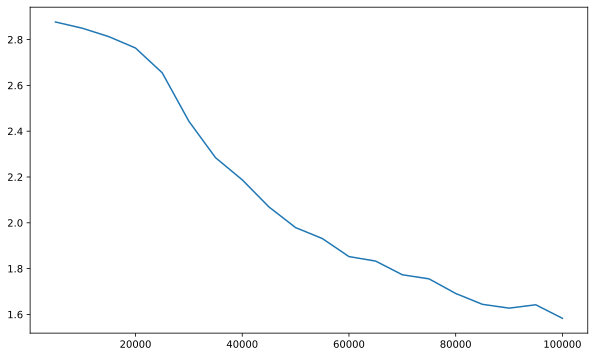

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iterations, losses)
plt.show()

Look at the predictions.

In [ ]:
def evaluate(rnn, name_tensor):
    # read the sequence and return the final output
    hidden = rnn.h0()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

In [ ]:
def predict(input_name, n_predictions=3):
    print('\n> %s' % input_name)
    with torch.no_grad():
        output = evaluate(rnn, name_to_tensor(input_name, all_letters))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Satoshi')
predict('Khoroshenkikh')
predict('Hinton')
predict('Bengio')
predict('Varathikul')


> Satoshi
(-0.92) Japanese
(-1.70) Italian
(-2.00) Polish

> Khoroshenkikh
(-0.31) Russian
(-1.91) Irish
(-3.10) Japanese

> Hinton
(-1.29) Scottish
(-1.47) Irish
(-1.91) English

> Bengio
(-0.91) Portuguese
(-1.40) Italian
(-1.66) Spanish

> Varathikul
(-0.95) Irish
(-1.19) Russian
(-2.76) Czech


<!--@slideshow slide-->
# [OPTIONAL] Colab demo: language model with RNN

`LanguageModelRNN` implements a Recurrent Neural Network for language modeling.

We will train many language models for different languages at once using _conditioning_. It means that for each sequence we will add the category to the input.

- Read the input sequence $x_1, x_2, \dots, x_t, \dots$
- The input sequence has the category $c$.
- Outputs are probability distributions over letters.
- Update hidden states and outputs according to RNN equations:
$$
h_t = f(h_{t-1}, x_t, \color{red}{c})
$$
$$
y_t = g(h_t)
$$
- For each $t$, the target output is the next letter (with a special character for the end of a sequence). For example:
<table>
<thead>
  <tr>
    <th>t</th>
    <th>input</th>
    <th>target output</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>1</td>
    <td>T</td>
    <td>u</td>
  </tr>
  <tr>
    <td>2</td>
    <td>u</td>
    <td>r</td>
  </tr>
  <tr>
    <td>3</td>
    <td>r</td>
    <td>i</td>
  </tr>
  <tr>
    <td>4</td>
    <td>i</td>
    <td>n</td>
  </tr>
  <tr>
    <td>4</td>
    <td>n</td>
    <td>g</td>
  </tr>
  <tr>
    <td>6</td>
    <td>g</td>
    <td>&lt;EOS&gt;</td>
  </tr>
</tbody>
</table>


In [ ]:
import torch
import torch.nn as nn

class LanguageModelRNN(nn.Module):
    def __init__(self, input_size, category_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # category -> hidden
        self.ch = nn.Linear(category_size, hidden_size)
        # hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, c, x, h):
        # h_t = f(h_{t-1}, x_t, c)
        hidden = self.relu(self.hh(h) + self.xh(x) + self.ch(c))
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
def process_sequence_language_model(
    category_tensor,
    input_line_tensor,
    target_line_tensor,
    learning_rate
):
    loss_function = nn.NLLLoss()
    hidden = rnn.h0()
    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        # update the loss for each element x_t
        l = loss_function(output, target_line_tensor[i])
        loss += l

    loss.backward()

    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item() / input_line_tensor.size(0)

In [ ]:
# One-hot vector for category
def get_category_tensor(category, all_categories):
    li = all_categories.index(category)
    tensor = torch.zeros(1, len(all_categories))
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including <EOS>) for input
def get_input_tensor(line, all_letters):
    n_letters = len(all_letters) + 1
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.index(letter)] = 1
    return tensor

# LongTensor of second letter to end (<EOS>) for target
def get_target_tensor(line, all_letters):
    n_letters = len(all_letters) + 1
    letter_indexes = [all_letters.index(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # <EOS>
    return torch.LongTensor(letter_indexes).unsqueeze(-1)

In [ ]:
n_letters = len(all_letters) + 1  # Plus EOS marker
n_categories = len(all_categories)
rnn = LanguageModelRNN(n_letters, n_categories, 128, n_letters)

In [ ]:
n_iters = 100000
print_every = 5000
all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):
    # sample categories uniformly
    random_category = random.choice(all_categories)
    sample_idx = random.choice(range(len(category_to_training_samples[random_category])))
    category_tensor, line_tensor = category_to_training_samples[random_category][sample_idx]
    name = category_to_names[random_category][sample_idx]

    category_tensor = get_category_tensor(random_category, all_categories)
    input_tensor = get_input_tensor(name, all_letters)
    target_tensor = get_target_tensor(name, all_letters)
    loss = process_sequence_language_model(
        category_tensor,
        input_tensor,
        target_tensor,
        0.0005
    )

    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: loss {avg_loss}")

  0%|          | 0/100000 [00:00<?, ?it/s]

iteration 5000: loss 2.913215218382486
iteration 10000: loss 2.646390229992668
iteration 15000: loss 2.5305974451389126
iteration 20000: loss 2.46289156672619
iteration 25000: loss 2.401759818629799
iteration 30000: loss 2.3435903177436788
iteration 35000: loss 2.33162259020546
iteration 40000: loss 2.2746990540677006
iteration 45000: loss 2.2424993710251613
iteration 50000: loss 2.2260588591697275
iteration 55000: loss 2.197818441334785
iteration 60000: loss 2.1806628885602737
iteration 65000: loss 2.1475203101058793
iteration 70000: loss 2.1309962029339427
iteration 75000: loss 2.11852954841207
iteration 80000: loss 2.100268720910657
iteration 85000: loss 2.102128786282851
iteration 90000: loss 2.0670860673415867
iteration 95000: loss 2.064981788256723
iteration 100000: loss 2.0441920813378127


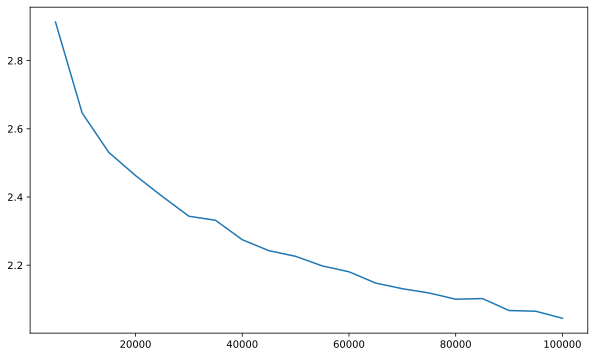

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iterations, losses)
plt.show()

Sampling

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = get_category_tensor(category, all_categories)
        input_tensor = get_input_tensor(start_letter, all_letters)
        hidden = rnn.h0()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input_tensor[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input_tensor = get_input_tensor(letter, all_letters)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Roshin
Uakinov
Sharinov
Gerter
Erenger
Roun
Sarana
Parez
Alane
Chan
Han
Iun


<!--@slideshow slide-->
# Summary
1. Recurrent functions accept sequences as inputs
1. Recurrent Neural Networks are recurrent _layers_: they consist of linear transformations followed by activation functions
1. RNNs are trained with backpropagation on "unrolled" computational graph
1. Examples of tasks solved by RNNs: classification and language modeling

<!--@slideshow slide-->
# Recommended resources
- [CS224n Lecture 6: Language Models and Recurrent Neural Networks](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/slides/cs224n-2019-lecture06-rnnlm.pdf)
- [CS231n Lecture 10: Recurrent Neural Networks](http://cs231n.stanford.edu/slides/2016/winter1516_lecture10.pdf)
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
- [NLP FROM SCRATCH: GENERATING NAMES WITH A CHARACTER-LEVEL RNN](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)

<!--@slideshow slide-->
# Home Assignment

You are given the dataset with startup investments information: [link](https://www.kaggle.com/arindam235/startup-investments-crunchbase). It contains columns `name` and `market`.

## Exercise 1
- Find top 10 markets.
- Get startup names that have markets from top-10.
- Create tensors for `ClassificationRNN`. Encode each market with `sklearn.preprocessing.LabelEncoder`.

## Exercise 2
Predict market given a startup name. Use tensors from the Exercise 1.

In [ ]:
import pandas as pd
df = pd.read_csv("harbour-space-text-mining-course/datasets/startup_investments/investments_VC.csv")
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11,15,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,...,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,Unnamed: 39
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,...,0,0,0,0,0,0,0,0,0,NaN
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,...,0,0,0,0,0,0,0,0,0,NaN
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000,operating,EST,NaN,Tallinn,...,0,0,0,0,0,0,0,0,0,NaN
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,...,0,0,0,0,0,0,0,0,0,NaN
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000,operating,USA,TX,Dallas,...,0,0,0,0,0,0,0,0,0,NaN


In [ ]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
data = df
top_10_markets = data.groupby("market").size().sort_values(ascending=False).head(10)
data_top_10 = data.loc[data['market'].isin(top_10_markets.index)]
markets = data_top_10['market'].unique()
startup_names = data_top_10["name"].values
le = LabelEncoder()
encoded_market = le.fit_transform(markets)
market_tensor = torch.tensor(encoded_market)


In [ ]:
class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # instead of explicit matrix multiplications, we use Linear layers
        # W_hh: hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # W_xh: input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # W_hy: hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)

        # nonlinearities we will use:
        # ReLU for h_t = f(h_{t-1}, x_t)
        self.relu = nn.ReLU()
        # LogSoftmax for y_t = g(h_t) (because we are doing classification)
        # for binary classification, it is 1 / (1 + exp(-x))
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden size for initialization of h_0
        self.hidden_size = hidden_size

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # y_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        # compute the initial value (all zeros) for the hidden state
        return torch.zeros(1, self.hidden_size)

In [ ]:
def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    """
    The algorithm:
    - Read the input sequence (stored in `input_tensor`) left-to-right
    - At each step, compute new hidden state and new output
    - Get the last output (probability distribution over classes) and compute loss
    - Backpropagate gradients and update parameters

    input_tensor is a 3-dimensional tensor: sequence length * 1 * vocabulary size
     - the first dimension: each element in this dimension corresponds to x_t
     - the second dimension is a "batch dimension", in our case it always contains 1 element
     - the last dimension contains components of x_t
    """

    # prepare for backprop
    rnn.zero_grad()
    # initialize hidden state
    hidden = rnn.h0()

    # read all elements of the input sequence, update hidden state and output
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    # get the last output, compute the loss function and backpropagate
    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    # update parameters
    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

In [ ]:
# count the total number of letters
all_letters = set()
all_categories = set()

for name in startup_names:
    all_letters.update(list(name))
all_letters = list(sorted(all_letters))
all_categories = list(sorted(markets))

In [ ]:
category_to_training_samples = defaultdict(list)
for category in markets:
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    for name in data_top_10.loc[data_top_10['market']==category]:
        name_tensor = name_to_tensor(name, all_letters)
        sample = category_tensor, name_tensor
        category_to_training_samples[category].append(sample)

In [ ]:
n_hidden = 128
rnn = ClassificationRNN(len(all_letters), n_hidden, len(all_categories))

In [ ]:
import math
from tqdm.notebook import tqdm
import random
import numpy as np
random.seed(0)

n_iters = 100000
print_every = 5000

# Keep track of losses for plotting
all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):
    # sample categories uniformly
    random_category = random.choice(all_categories)
    market_tensor, name_tensor = random.choice(category_to_training_samples[random_category])
    # process sequence: update RNN weights and compute loss
    loss = process_sequence_classification(rnn, market_tensor, name_tensor, 0.001)
    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: loss {avg_loss}")

  0%|          | 0/100000 [00:00<?, ?it/s]

iteration 5000: loss 2.30446179189682
iteration 10000: loss 2.3025895147800446
iteration 15000: loss 2.3036773449897767
iteration 20000: loss 2.3029609098434447
iteration 25000: loss 2.303648769044876
iteration 30000: loss 2.3036512538433076
iteration 35000: loss 2.3023308916568754
iteration 40000: loss 2.30398541431427
iteration 45000: loss 2.3034402153491973
iteration 50000: loss 2.30287845826149
iteration 55000: loss 2.3034664837837218
iteration 60000: loss 2.303165545511246
iteration 65000: loss 2.3031728848457336
iteration 70000: loss 2.302920811510086
iteration 75000: loss 2.3033639119148255
iteration 80000: loss 2.302890433359146
iteration 85000: loss 2.302776765012741
iteration 90000: loss 2.303674197769165
iteration 95000: loss 2.3033823462486267
iteration 100000: loss 2.303368181324005


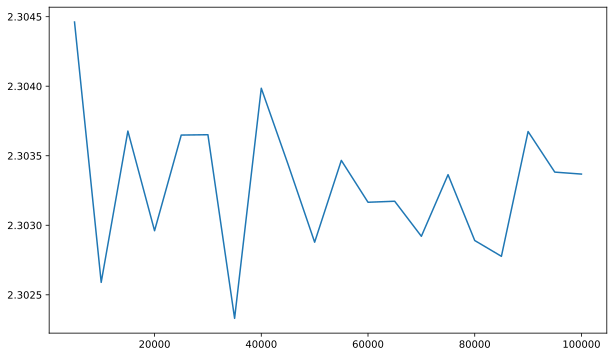

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iterations, losses)
plt.show()

**As the best result is in 35000 iteration so next time we can train the model with 37000 iteration**

In [ ]:
import math
from tqdm.notebook import tqdm
import random
import numpy as np
random.seed(0)

n_iters = 37000
print_every = 5000

# Keep track of losses for plotting
all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):
    # sample categories uniformly
    random_category = random.choice(all_categories)
    market_tensor, name_tensor = random.choice(category_to_training_samples[random_category])
    # process sequence: update RNN weights and compute loss
    loss = process_sequence_classification(rnn, market_tensor, name_tensor, 0.001)
    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: loss {avg_loss}")

  0%|          | 0/37000 [00:00<?, ?it/s]

iteration 5000: loss 2.3016121126651763
iteration 10000: loss 2.3025024845600126
iteration 15000: loss 2.30287619805336
iteration 20000: loss 2.302772510576248
iteration 25000: loss 2.3030530960083007
iteration 30000: loss 2.3028239887714386
iteration 35000: loss 2.301690816307068


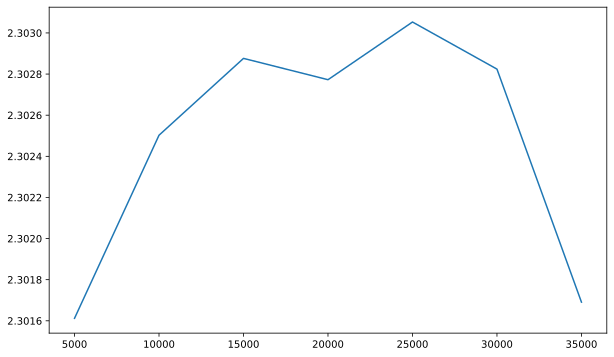

In [ ]:
import matplotlib.pyplot as plt

plt.plot(iterations, losses)
plt.show()

In [ ]:
def evaluate(rnn, name_tensor):
    # read the sequence and return the final output
    hidden = rnn.h0()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

In [ ]:
def predict(input_name, n_predictions=3):
    print('\n> %s' % input_name)
    with torch.no_grad():
        output = evaluate(rnn, name_to_tensor(input_name, all_letters))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [ ]:
predict('facebook')
predict('meta')
predict('steam')


> facebook
(-2.23)  Games 
(-2.27)  Hardware + Software 
(-2.29)  Biotechnology 

> meta
(-2.26)  Hardware + Software 
(-2.27)  Games 
(-2.28)  Health Care 

> steam
(-2.26)  Hardware + Software 
(-2.27)  Games 
(-2.27)  E-Commerce 
